In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import bayesflow as bf
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.benchmarks import Benchmark
from bayesflow.helper_networks import ConfigurableMLP
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.summary_networks import DeepSet

np.random.seed(2024)


In [17]:
#先验分布
# 定义Inverse Gamma先验分布
def batch_prior_fun(batch_size):
    # 先验: InverseGamma(alpha, beta)
    alpha, beta = 2.0, 1.0  # 推荐参数
    dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)
    return dist.sample((batch_size, 1))

# 定义模拟器
def batch_simulator_fun(gamma, n_obs=1000, mu=0):
    # 使用gamma作为方差生成观测值，假设Y ~ N(mu, gamma)
    return tf.random.normal((gamma.shape[0], n_obs), mean=mu, stddev=tf.sqrt(gamma))[:, :, None]

# prior = Prior(batch_prior_fun=batch_prior_fun)
# simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
# generative_model = GenerativeModel(prior=prior, simulator=simulator)

In [18]:
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.helper_networks import ConfigurableMLP

prior = Prior(batch_prior_fun=batch_prior_fun)
simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

# 定义推断网络
summary_dim = 10
summary_net = DeepSet(summary_dim)

inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=1, dropout_rate=0.1)

amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=1)


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [19]:
# 定义配置器
def config(forward_dict):
    """Helper function for posterior configuration."""
    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"]
    input_dict["summary_conditions"] = forward_dict["sim_data"]
    return input_dict

# 定义Trainer
from bayesflow.trainers import Trainer
trainer = Trainer(
    amortizer=amortizer,
    configurator=config,
    generative_model=generative_model
)

# 开始训练
h = trainer.train_online(1, 500, batch_size=32)


INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
Training epoch 1: 100%|██████████| 500/500 [00:26<00:00, 18.60it/s, Epoch: 1, Iter: 500,Loss: 0.051,Avg.Loss: 0.105,LR: 4.93E-09]


In [45]:
# 定义测试数据
num_test = 1000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * 0.3  # gamma = 1 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [46]:
# 使用推断器估计gamma
estimates = amortizer.estimate(test_data)[:, 0]
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])
summary_conditions.shape

TensorShape([1000, 1])

In [54]:
def bayes_estimator(Z, mu_0=0, alpha_0=2, beta_0=1):
    """
    实现贝叶斯估计器，根据先验和观测数据计算后验分布，并从中采样。
    
    参数：
    - Z: 输入数据，形状为 TensorShape([n, 1])。
    - mu_0: 先验均值 (prior mean)。
    - alpha_0: Inverse-Gamma 分布的初始形状参数。
    - beta_0: Inverse-Gamma 分布的初始尺度参数。
    
    返回：
    - posterior_samples: 从后验分布中采样的 1000 个样本。
    """
    # 确保 Z 是 TensorFlow 张量
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # 计算观测数据的均值 y_bar 和数量 n
    y_bar = tf.reduce_mean(Z)  # 样本均值
    n = tf.cast(Z.shape[0], tf.float32)  # 样本数量

    # 计算每个数据减去 mu_0 的平方和
    variance = tf.reduce_sum(tf.square(Z - y_bar))  # 数据的平方和

    # 更新 Inverse-Gamma 分布的后验参数
    alpha = alpha_0 + n / 2
    beta = beta_0 + variance / 2 

    # 定义后验分布
    dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)

    # 从后验分布中采样
    posterior_samples = dist.sample(1000).numpy()
    return posterior_samples

# 摊开数据
# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# 调用 bayes_estimator
reference = bayes_estimator(summary_conditions)
# reference = bayes_estimator(test_data["summary_conditions"])

/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_24553/1013731118.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


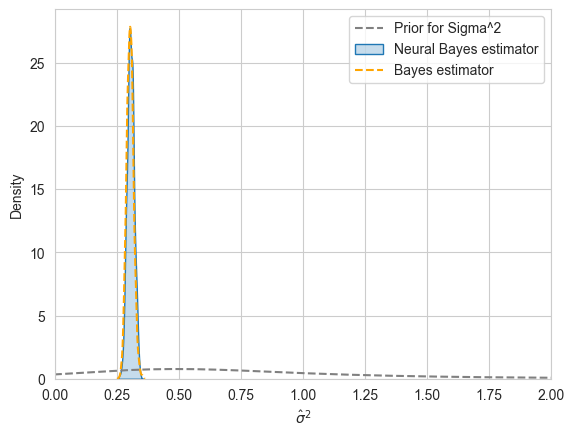

In [65]:
# 定义miu的先验分布为逆伽马分布
prior_dist = tfp.distributions.InverseGamma(2.0, 1.0)

# 从该分布中采样 1000 个点
prior_samples = prior_dist.sample(1000).numpy()

# 设置 x 轴范围
plt.xlim(0, 2)

# 绘制先验分布
sns.kdeplot(prior_samples, label="Prior for Sigma^2", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator",color = "orange", linestyle="--")
plt.xlabel(r"$\hat\sigma^2$")
_ = plt.legend()

/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_24553/3319464667.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


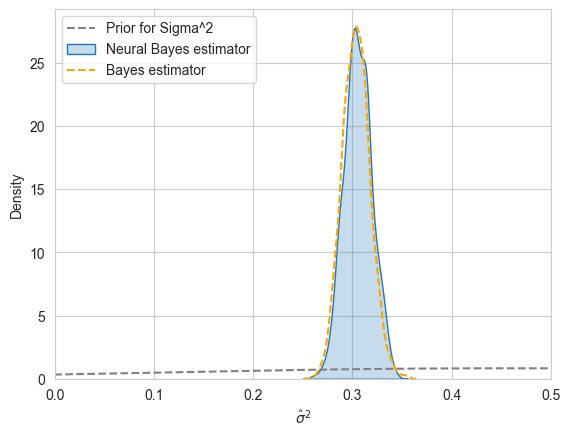

In [64]:
# 定义miu的先验分布为逆伽马分布
prior_dist = tfp.distributions.InverseGamma(2.0, 1.0)

# 从该分布中采样 1000 个点
prior_samples = prior_dist.sample(1000).numpy()

# 设置 x 轴范围
plt.xlim(0, 0.5)

# 绘制先验分布
sns.kdeplot(prior_samples, label="Prior for Sigma^2", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator",color = "orange", linestyle="--")
plt.xlabel(r"$\hat\sigma^2$")
_ = plt.legend()

In [67]:
# 定义测试数据
num_test = 1000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * 1  # gamma = 1 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [68]:
# 使用推断器估计gamma
estimates = amortizer.estimate(test_data)[:, 0]
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])
summary_conditions.shape

TensorShape([1000, 1])

In [69]:
def bayes_estimator(Z, mu_0=0, alpha_0=2, beta_0=1):
    """
    实现贝叶斯估计器，根据先验和观测数据计算后验分布，并从中采样。
    
    参数：
    - Z: 输入数据，形状为 TensorShape([n, 1])。
    - mu_0: 先验均值 (prior mean)。
    - alpha_0: Inverse-Gamma 分布的初始形状参数。
    - beta_0: Inverse-Gamma 分布的初始尺度参数。
    
    返回：
    - posterior_samples: 从后验分布中采样的 1000 个样本。
    """
    # 确保 Z 是 TensorFlow 张量
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # 计算观测数据的均值 y_bar 和数量 n
    y_bar = tf.reduce_mean(Z)  # 样本均值
    n = tf.cast(Z.shape[0], tf.float32)  # 样本数量

    # 计算每个数据减去 mu_0 的平方和
    variance = tf.reduce_sum(tf.square(Z - y_bar))  # 数据的平方和

    # 更新 Inverse-Gamma 分布的后验参数
    alpha = alpha_0 + n / 2
    beta = beta_0 + variance / 2 

    # 定义后验分布
    dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)

    # 从后验分布中采样
    posterior_samples = dist.sample(1000).numpy()
    return posterior_samples

# 摊开数据
# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# 调用 bayes_estimator
reference = bayes_estimator(summary_conditions)
# reference = bayes_estimator(test_data["summary_conditions"])

/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_24553/1013731118.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


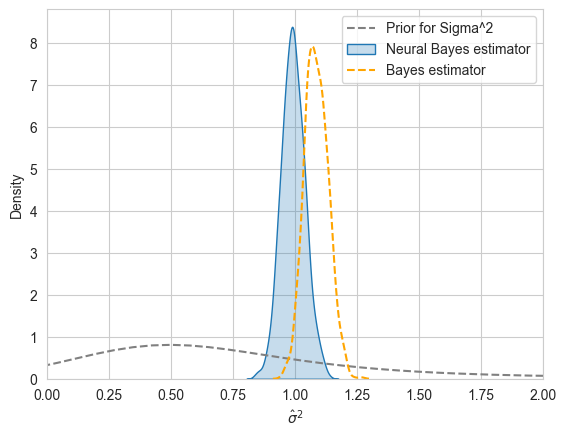

In [70]:
# 定义miu的先验分布为逆伽马分布
prior_dist = tfp.distributions.InverseGamma(2.0, 1.0)

# 从该分布中采样 1000 个点
prior_samples = prior_dist.sample(1000).numpy()

# 设置 x 轴范围
plt.xlim(0, 2)

# 绘制先验分布
sns.kdeplot(prior_samples, label="Prior for Sigma^2", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator",color = "orange", linestyle="--")
plt.xlabel(r"$\hat\sigma^2$")
_ = plt.legend()